Raw Data:
   Unnamed: 0     contributors  freeCodeCamp  free-programming-books  awesome  \
0           0        camperbot        1536.0                     NaN      NaN   
1           1      raisedadead        1487.0                     NaN      NaN   
2           2  ojeytonwilliams        1303.0                     NaN      NaN   
3           3    renovate[bot]        1262.0                     NaN      NaN   
4           4            sahat        1261.0                     NaN      NaN   

   build-your-own-x  public-apis  coding-interview-university  \
0               NaN          NaN                          NaN   
1               NaN          NaN                          NaN   
2               NaN          NaN                          NaN   
3               NaN          NaN                          NaN   
4               NaN          NaN                          NaN   

   developer-roadmap  system-design-primer  ...  django  app-ideas  bitcoin  \
0                NaN             

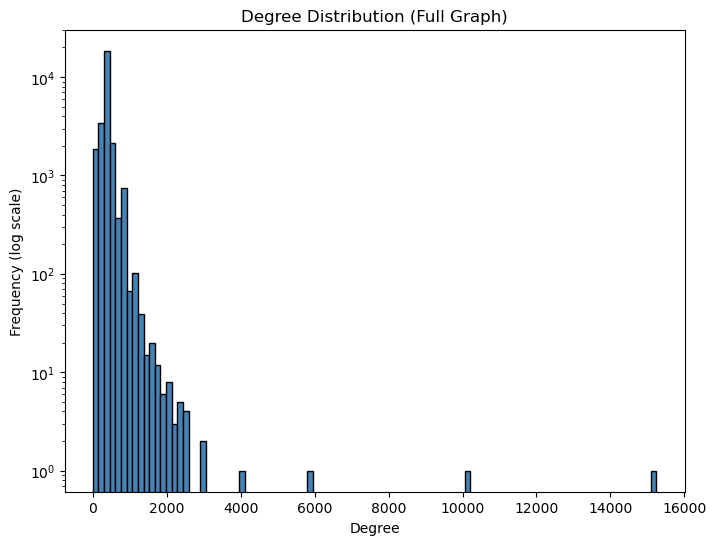


Top 10 nodes by Degree Centrality (Full Graph):
  dependabot[bot]: 0.5573
  eltociear: 0.3720
  github-actions[bot]: 0.2160
  jsoref: 0.1482
  spekulatius: 0.1095
  0xflotus: 0.1084
  dependabot-preview[bot]: 0.0938
  m1guelpf: 0.0930
  SimenB: 0.0919
  jamesgeorge007: 0.0916

Top 10 nodes by Approximate Betweenness Centrality (Full Graph):
  dependabot[bot]: 0.3267
  eltociear: 0.1003
  github-actions[bot]: 0.0530
  proppy: 0.0147
  imba-tjd: 0.0130
  ReadmeCritic: 0.0103
  BandhiyaHardik: 0.0103
  0xflotus: 0.0102
  jsoref: 0.0100
  akx: 0.0093

Top 10 nodes by Eigenvector Centrality (Full Graph):
  dependabot[bot]: 0.1530
  eltociear: 0.1186
  github-actions[bot]: 0.0699
  jamesgeorge007: 0.0569
  karlhorky: 0.0543
  styfle: 0.0535
  SimenB: 0.0522
  Andarist: 0.0516
  chentsulin: 0.0494
  arcanis: 0.0487

Top 10 nodes by PageRank (Full Graph):
  dependabot[bot]: 0.0013
  eltociear: 0.0009
  github-actions[bot]: 0.0005
  rustdesk: 0.0003
  jsoref: 0.0003
  0xflotus: 0.0003
  Readme

In [1]:
# DSC291_Final_Project_FinalVersion(v4).ipynb
# -------------------------------------------------------------
# This notebook loads your CSV data, preprocesses it, constructs
# a bipartite graph, and then projects it to a contributor network.
# We then perform a fundamental analysis on the full graph (basis stats,
# centrality measures, and degree distribution) before applying any
# filtering for visualization.
#
# Further optimizations include:
#  - using approximate betweenness centrality by sampling (via k parameter)
#  - optional filtering (by degree or edge weight) for manageable visualization
#  - robustness simulation on the filtered subgraph
# -------------------------------------------------------------

import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
import copy, random
import numpy as np
import matplotlib.pyplot as plt

#####################
# 1. DATA LOADING  #
#####################
csv_file = "top_100_stars_nodes_df.csv"
df_raw = pd.read_csv(csv_file)
print("Raw Data:")
print(df_raw.head())

# We assume the CSV is in wide format with a 'contributors' column.
# If 'Unnamed: 0' is present, we drop it. Then we fill NaNs with 0.
if 'contributors' in df_raw.columns:
    df_clean = df_raw.set_index('contributors')
    if 'Unnamed: 0' in df_clean.columns:
        df_clean.drop(columns=['Unnamed: 0'], inplace=True)
    df_clean = df_clean.fillna(0)
    print("Data assumed to be in pivoted wide format.")
else:
    # If your CSV was in long format, pivot it:
    df_clean = df_raw.pivot_table(index='contributor',
                                  columns='repo',
                                  values='contributions',
                                  fill_value=0)
    print("Pivoted data (long -> wide).")

print(df_clean.head())

# If the index isn't unique, group duplicates (sum contributions).
if not df_clean.index.is_unique:
    df_clean = df_clean.groupby(df_clean.index).sum()

print("Is the index unique now?", df_clean.index.is_unique)
print(df_clean.head())

##########################
# 2. BIPARTITE BUILDING  #
##########################
B = nx.Graph()

# Extract contributors & repos
contributors = list(df_clean.index)
repos = list(df_clean.columns)

# Add nodes to the bipartite graph
B.add_nodes_from(contributors, bipartite='contributors')
B.add_nodes_from(repos, bipartite='repos')

# Build edges only if there's at least 1 contribution.
EDGE_THRESHOLD = 1  # Only add edge if contributions >= 1
for contributor in contributors:
    for repo in repos:
        contrib_count = float(df_clean.at[contributor, repo])
        if contrib_count >= EDGE_THRESHOLD:
            B.add_edge(contributor, repo, weight=contrib_count)

print("Bipartite graph created:")
print(f"  #Contributor nodes: {len(contributors)}")
print(f"  #Repo nodes: {len(repos)}")
print(f"  #Edges in bipartite graph: {B.number_of_edges()}")

# Project bipartite -> contributor network
G = bipartite.weighted_projected_graph(B, contributors)
print("Contributor collaboration network:")
print(f"  Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

######################################################
# FUNDAMENTAL ANALYSIS (FULL GRAPH) BEFORE FILTERING #
######################################################
print("\n----- Fundamental Analysis on Full Graph -----")

# Basic network statistics
total_nodes = G.number_of_nodes()
total_edges = G.number_of_edges()
print(f"Total Nodes (Full Graph): {total_nodes}")
print(f"Total Edges (Full Graph): {total_edges}")

# Compute degree for every node
degrees = np.array([d for n, d in G.degree()])
print("\nDegree Statistics (Full Graph):")
print("  Min degree:", degrees.min())
print("  Max degree:", degrees.max())
print("  Mean degree:", degrees.mean())
print("  Median degree:", np.median(degrees))

# Plot the degree distribution (using log scale on y-axis)
plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=100, color='steelblue', edgecolor='black', log=True)
plt.title("Degree Distribution (Full Graph)")
plt.xlabel("Degree")
plt.ylabel("Frequency (log scale)")
plt.show()

# --- Centrality Measures on the Full Graph ---
# Degree Centrality
deg_cent_full = nx.degree_centrality(G)
top10_deg_full = sorted(deg_cent_full.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 nodes by Degree Centrality (Full Graph):")
for node, cent in top10_deg_full:
    print(f"  {node}: {cent:.4f}")

# Betweenness Centrality (approximate using k=100 for sampling)
try:
    betw_cent_full = nx.betweenness_centrality(G, k=100, normalized=True)
    top10_betw_full = sorted(betw_cent_full.items(), key=lambda x: x[1], reverse=True)[:10]
    print("\nTop 10 nodes by Approximate Betweenness Centrality (Full Graph):")
    for node, cent in top10_betw_full:
        print(f"  {node}: {cent:.4f}")
except Exception as e:
    print("Betweenness Centrality computation failed:", e)

# Eigenvector Centrality
try:
    eig_cent_full = nx.eigenvector_centrality(G, max_iter=1000)
    top10_eig_full = sorted(eig_cent_full.items(), key=lambda x: x[1], reverse=True)[:10]
    print("\nTop 10 nodes by Eigenvector Centrality (Full Graph):")
    for node, cent in top10_eig_full:
        print(f"  {node}: {cent:.4f}")
except Exception as e:
    print("Eigenvector Centrality computation failed:", e)

# PageRank
try:
    pagerank_full = nx.pagerank(G)
    top10_pr_full = sorted(pagerank_full.items(), key=lambda x: x[1], reverse=True)[:10]
    print("\nTop 10 nodes by PageRank (Full Graph):")
    for node, pr in top10_pr_full:
        print(f"  {node}: {pr:.4f}")
except Exception as e:
    print("PageRank computation failed:", e)

############################
# 3. OPTIONAL SUBGRAPHING  #
############################
# For visualization and advanced computations, we now filter the full graph.
# Here, we keep nodes with degree >= a threshold (DEGREE_FILTER).
DEGREE_FILTER = 463
filtered_nodes = [n for n, deg in G.degree() if deg >= DEGREE_FILTER]
G_filtered = G.subgraph(filtered_nodes).copy()
print(f"\nFiltered subgraph with degree >= {DEGREE_FILTER}:")
print(f"  Nodes: {G_filtered.number_of_nodes()}, Edges: {G_filtered.number_of_edges()}")

##################################
# 4. CENTRALITY & COMMUNITY (FILTERED)
##################################
# Compute centrality measures on the filtered subgraph.
deg_centrality_filt = nx.degree_centrality(G_filtered)
closeness_centrality_filt = nx.closeness_centrality(G_filtered)
eigenvector_centrality_filt = nx.eigenvector_centrality(G_filtered, max_iter=1000)
pagerank_filt = nx.pagerank(G_filtered)

# Store them as attributes in the filtered graph
for node in G_filtered.nodes():
    G_filtered.nodes[node]['deg_cent'] = deg_centrality_filt[node]
    G_filtered.nodes[node]['clos_cent'] = closeness_centrality_filt[node]
    G_filtered.nodes[node]['eig_cent'] = eigenvector_centrality_filt[node]
    G_filtered.nodes[node]['pagerank'] = pagerank_filt[node]

top10_deg_filt = sorted(deg_centrality_filt.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 nodes by Degree Centrality (Filtered):")
for nd, sc in top10_deg_filt:
    print(f"  {nd}: {sc:.4f}")

try:
    betw_centrality_filt = nx.betweenness_centrality(G_filtered, k=100, normalized=True)
    top10_betw_filt = sorted(betw_centrality_filt.items(), key=lambda x: x[1], reverse=True)[:10]
    print("\nTop 10 nodes by Approximate Betweenness Centrality (Filtered):")
    for nd, sc in top10_betw_filt:
        print(f"  {nd}: {sc:.4f}")
except Exception as e:
    print("Betweenness Centrality (Filtered) computation failed:", e)

try:
    top10_eig_filt = sorted(eigenvector_centrality_filt.items(), key=lambda x: x[1], reverse=True)[:10]
    print("\nTop 10 nodes by Eigenvector Centrality (Filtered):")
    for nd, sc in top10_eig_filt:
        print(f"  {nd}: {sc:.4f}")
except Exception as e:
    print("Eigenvector Centrality (Filtered) computation failed:", e)

top10_pr_filt = sorted(pagerank_filt.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 nodes by PageRank (Filtered):")
for nd, pr in top10_pr_filt:
    print(f"  {nd}: {pr:.4f}")

##############################
# 5. COMMUNITY DETECTION (FILTERED)
##############################
import community as community_louvain

partition_filt = community_louvain.best_partition(G_filtered)
for node, comm in partition_filt.items():
    G_filtered.nodes[node]['community'] = comm

num_coms_filt = len(set(partition_filt.values()))
print(f"\nDetected {num_coms_filt} communities in the filtered subgraph.")

###########################################
# 6. ROBUSTNESS SIMULATION (FILTERED ONLY)
###########################################
def largest_component_size(graph):
    if graph.number_of_nodes() == 0:
        return 0
    return len(max(nx.connected_components(graph), key=len))

G_targeted = copy.deepcopy(G_filtered)
G_random = copy.deepcopy(G_filtered)

targeted_nodes = sorted(G_targeted.degree(), key=lambda x: x[1], reverse=True)
component_sizes_targeted = []

print("\nStarting targeted removal simulation (Filtered Subgraph):")
for i, (node, _) in enumerate(targeted_nodes):
    G_targeted.remove_node(node)
    if (i + 1) % 50 == 0:
        size = largest_component_size(G_targeted)
        component_sizes_targeted.append(size)
        print(f"  Removed {i+1} nodes, largest component size: {size}")

nodes_random = list(G_random.nodes())
random.shuffle(nodes_random)
component_sizes_random = []

print("\nStarting random removal simulation (Filtered Subgraph):")
for i, node in enumerate(nodes_random):
    G_random.remove_node(node)
    if (i + 1) % 50 == 0:
        size = largest_component_size(G_random)
        component_sizes_random.append(size)
        print(f"  Removed {i+1} nodes, largest component size: {size}")

######################################
# 7. EXPORT FOR VISUALIZATION
######################################
# (Optional) Export the filtered subgraph to Gephi for further exploration.
# nx.write_gexf(G_filtered, "github_collaboration_filtered.gexf")
# print("Filtered subgraph exported to github_collaboration_filtered.gexf")

############################
# END OF NOTEBOOK
############################

# Summary of Optimizations:
# - Data is loaded and cleaned from a CSV, with duplicate contributors aggregated.
# - A bipartite graph is built (contributors vs. repos) and then projected to create the full contributor network.
# - Fundamental analysis is performed on the full graph (basic stats, degree distribution,
#   and centrality measures including Degree, Betweenness, Eigenvector, and PageRank), providing an overall view before filtering.
# - The graph is then filtered by a degree threshold (DEGREE_FILTER) for manageability.
# - Centrality and community detection are computed on the filtered subgraph.
# - Robustness simulations are run on the filtered subgraph to assess network resilience.
#
# Adjust thresholds as needed to balance capturing network structure with performance constraints.
